# Contents
1. [Introduction](#intro)   
2. [Getting started](#start)  
3. [The listings file](#listings)  
    3.1. [Neighborhood differences](#hoods)  
    3.2. [Capacity](#capacity)    
    3.3. [Review scores](#scores)  
    3.4. [Amenities](#amenities)  
4. [The calendar file](#calendar)  
    4.1. [Daily availability](#availability)  
    4.2. [Daily prices](#prices)  
5. [The reviews file](#reviews)  
6. [Price outliers](#outliers) 

# 1. Introduction
<a id='intro'></a>
In this notebook, we visually explore Seattle Airbnb listing data as of July 14th, 2019. These data are from [Inside Airbnb](http://insideairbnb.com/), a provider of scraped and cleaned Airbnb data from cities around the world.

There are three data files we will be working with:
* `listings.csv` - This file contains one row per listing and over fifty characteristics of each listing, such as location, price per night, average guest rating, number of rooms, and amenities.
* `calendar.csv` - This file contains roughly 365 rows for each Seattle listing - one for each day of the listing's calendar. Includes daily price information and availability for a year out from when the listing was last scraped.
* `reviews.csv` - This file contains a row for each Seattle listing review, which includes the full text of the review. There may be many reviews for a single listing or none at all yet.

Each listing has been assigned a unique ID, which can be used to combine the information from different data files.

# 2. Getting started
<a id='start'></a>

Import the libraries and modules we'll need:

In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import calmap
from IPython.display import Markdown, display
pd.plotting.register_matplotlib_converters()

Define convenience function for prettier text printing:

In [2]:
def print_quote(text):
    """Print text as markdown block quote"""
    display(Markdown('>' + text))

Set up formatting for plots:

In [3]:
plt.rcParams['figure.figsize'] = 15, 5
color_palette = ['#D36135', '#E6AA68', '#7FB069', '#A7BED3', '#1C77C3', '#995D81',
                 '#E85D75', '#FFC4EB', '#729EA1', '#476A6F', '#310A31', '#813405']
sns.set_palette(color_palette)
sns.set_style('whitegrid')
sns.set_context('notebook')

# 3. The listings file
<a id='listings'></a>
We'll start by taking a look at the listings file. First we'll read in the data, convert the price variable to a float, and set the property id as the index for the dataframe:

In [33]:
listings = pd.read_csv('data/listings_train.csv', low_memory=False)
listings.set_index('id', inplace=True)

We can confirm that all of the listings were scraped on the same date:

In [34]:
Counter(listings.last_scraped)

Counter({'2019-07-14': 7136})

## 3.1. Neighborhood differences
<a id='hoods'></a>
Let's take a look at how many listings are in each neighborhood group:

In [35]:
listings.groupby('neighbourhood_group_cleansed').size().sort_values(ascending=False)

neighbourhood_group_cleansed
Other neighborhoods    1323
Downtown               1196
Capitol Hill            801
Central Area            617
Queen Anne              506
West Seattle            408
Ballard                 382
Rainier Valley          367
Cascade                 297
Beacon Hill             279
University District     214
Delridge                211
Northgate               165
Magnolia                135
Lake City               131
Seward Park              69
Interbay                 35
dtype: int64

Now we'll plot the median price for each neighborhood group, along with a 95% confidence interval:

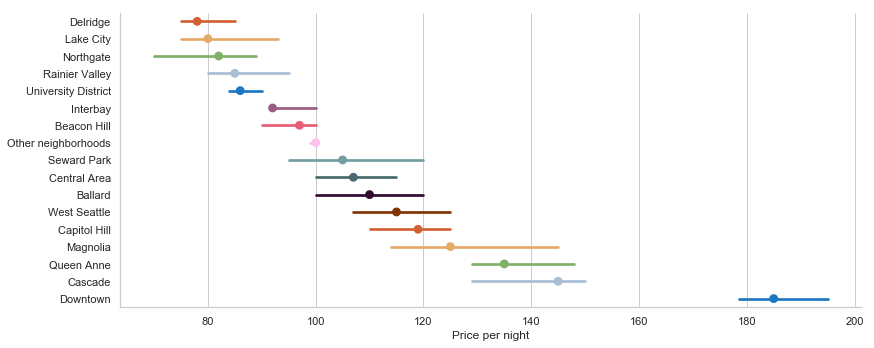

In [36]:
sorted_hoods = listings.groupby('neighbourhood_group_cleansed').price.median().sort_values().index
pt_plot = sns.catplot(x='price', y='neighbourhood_group_cleansed', data=listings, kind='point',
                      estimator=np.median, order=sorted_hoods, aspect=2.5, palette=color_palette)
pt_plot.set(xlabel='Price per night', ylabel='');

## 3.2. Capacity
<a id='capacity'></a>

Let's take a look at the relationship between capacity (number of guests the property can accommodate) and price. We'll add subplots for some of the major property types, which takes a bit of finessing:

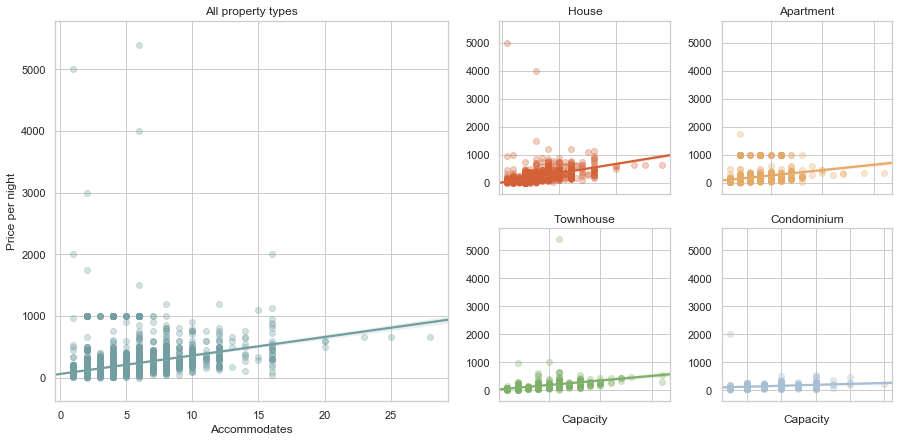

In [37]:
fig = plt.figure(figsize=(15, 7))
grid = plt.GridSpec(2, 4, hspace=0.2, wspace=0.3)

# Main plot for all property types
main_ax = fig.add_subplot(grid[:, :2])
sns.regplot(x='accommodates', y='price', data=listings,
            color=color_palette[8], ax=main_ax, scatter_kws={'alpha':.3})
main_ax.set(xlabel='Accommodates', ylabel='Price per night', title='All property types')

# Subplots for main property types
major_types = ['House', 'Apartment', 'Townhouse', 'Condominium']
type_i=0
for i in range(2):
    for j in range(2,4):
        ax=fig.add_subplot(grid[i, j], xticklabels=[], sharey=main_ax)
        sns.regplot(x=listings.accommodates[listings.property_type == major_types[type_i]],
                    y=listings.price[listings.property_type == major_types[type_i]],
                    color=color_palette[type_i], ax=ax, scatter_kws={'alpha':.3})
        ax.set(xlabel='', ylabel='', title=major_types[type_i])
        if i == 1:
            ax.set_xlabel('Capacity')
        type_i += 1

We see some extreme instances - listings where price per night is as much as \$5,000. We also see a cluster of properties listed for \$1,000 per night, set apart from other instances. We'll investigate these further in [Section 6](#outliers).

## 3.3. Review scores
<a id='scores'></a>

Review score information is housed in several columns. There is a column with the average overall review score for the listing, as well as average component review scores (for example, scores for cleanliness and location). There is also a number of reviews column - we can use this to see the proportion of listings that don't have any reviews yet:

In [38]:
(listings.number_of_reviews == 0).mean()

0.12724215246636772

So 12.7% of listings don't have any reviews yet. We may get a better performing model if we focus on listings that have actually been booked before. (There are a few other columns we can use to filter the listings to make sure they are properties that are actively rented out, as well - `calendar_updated`, when the calendar was last updated, and `last_review`, when the last review was written.)

Let's take a look at how the overall review score and component scores affect the price of the listing:

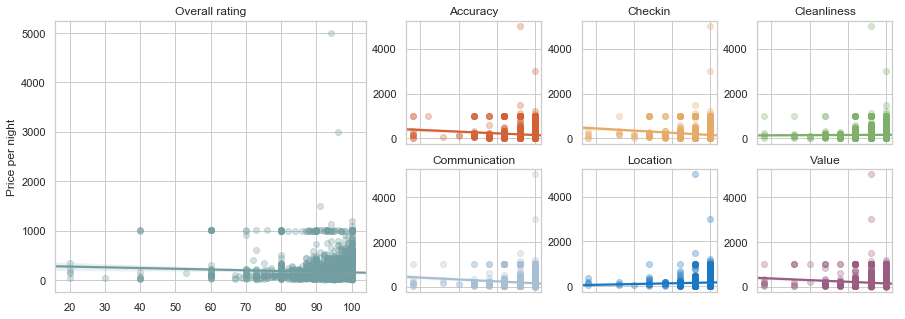

In [39]:
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(2, 5, hspace=0.2, wspace=0.3)

# Main plot for overall rating
main_ax = fig.add_subplot(grid[:, :2])
sns.regplot(x='review_scores_rating', y='price', data=listings,
            color=color_palette[8], ax=main_ax, scatter_kws={'alpha':.3})
main_ax.set(xlabel='', ylabel='Price per night', title='Overall rating')

# Subplots for specific scores
review_vars = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
review_labs = ['Accuracy', 'Checkin', 'Cleanliness', 'Communication', 'Location', 'Value']
var_i=0
for i in range(2):
    for j in range(2,5):
        ax=fig.add_subplot(grid[i, j], xticklabels=[])
        sns.regplot(x=review_vars[var_i], y='price', data=listings,
                    color=color_palette[var_i], ax=ax, scatter_kws={'alpha':.3})
        ax.set(xlabel='', ylabel='', title=review_labs[var_i])
        var_i += 1

Surprisingly, review scores are slightly negatively correlated with price. We also notice that there isn't a huge amount of variance in average review scores - most listings are rated high on average. In fact, about 85% of listings are rated 80 or above overall (which corresponds to four out of five stars or better):

In [40]:
(listings.review_scores_rating >= 80).mean()

0.8483744394618834

## 3.4. Amenities
<a id='amenities'></a>
The `amenities` column contains a set of amenities for each listing. For example, the amenities for one of the properties is recorded as:

In [44]:
listings.amenities[11867748]

'{TV,"Cable TV",Wifi,"Air conditioning",Kitchen,"Free parking on premises",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Self check-in","Smart lock","Private entrance",Bathtub,"Pack ’n Play/travel crib","Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics","Single level home","BBQ grill","Patio or balcony","Garden or backyard","No stairs or steps to enter","Wide entrance for guests","Flat path to guest entrance","Well-lit path to entrance","No stairs or steps to enter"}'

We can see all of the amenity possibilities, along with the number of listings that have them, with:

In [45]:
amenity_dict = Counter()
for index, row in listings.iterrows():
    listing_amenities = row.amenities.replace('{','').replace('}','').split(',')
    amenity_dict += Counter(listing_amenities)
amenity_dict.most_common()

[('Essentials', 6986),
 ('Wifi', 6981),
 ('Heating', 6900),
 ('"Smoke detector"', 6722),
 ('Shampoo', 6515),
 ('Kitchen', 6366),
 ('Hangers', 6282),
 ('"Hair dryer"', 6104),
 ('"Carbon monoxide detector"', 5985),
 ('"Laptop friendly workspace"', 5799),
 ('Iron', 5638),
 ('Washer', 5548),
 ('TV', 5546),
 ('Dryer', 5515),
 ('"Fire extinguisher"', 4665),
 ('"Hot water"', 4349),
 ('"Self check-in"', 4141),
 ('"First aid kit"', 3530),
 ('Refrigerator', 3510),
 ('"Dishes and silverware"', 3321),
 ('Microwave', 3292),
 ('"Coffee maker"', 3173),
 ('"Free parking on premises"', 3033),
 ('"Family/kid friendly"', 3021),
 ('"Bed linens"', 3001),
 ('"Free street parking"', 2993),
 ('"Private entrance"', 2986),
 ('Stove', 2936),
 ('"Cooking basics"', 2813),
 ('Oven', 2804),
 ('Internet', 2486),
 ('"Extra pillows and blankets"', 2485),
 ('Dishwasher', 2224),
 ('"Long term stays allowed"', 2137),
 ('Keypad', 2126),
 ('"No stairs or steps to enter"', 2118),
 ('"Lock on bedroom door"', 2103),
 ('"Cable 

Amenities range from the commonplace (toilet paper, TV, heating) to the obscure (bidet, steam oven). Some we expect to have greater impact on price - for instance, whether the property has a waterfront. Eventually we'll construct dummy variables for some of the amenity options. For example:

In [46]:
listings['has_wifi'] = ['Wifi' in amenities for amenities in listings.amenities]
listings['has_hottub'] = ['Hot tub' in amenities for amenities in listings.amenities]
listings['is_waterfront'] = ['Waterfront' in amenities for amenities in listings.amenities]

Now we can see how the price distributions differ with different combinations of amenities:

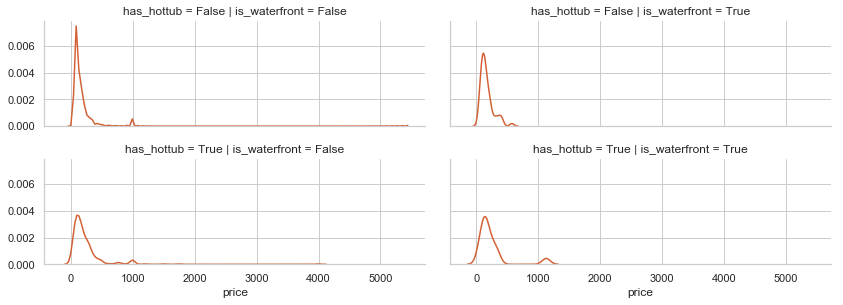

In [47]:
dist_plot = sns.FacetGrid(listings, col='is_waterfront', row='has_hottub', height=2.2, aspect=2.7)
dist_plot.map(sns.distplot, 'price', hist=False, hist_kws={'alpha':1});

The distributions look fairly similar, but prices are somewhat more concentrated at lower values when the listing isn't on the waterfront and doesn't have a hot tub.

# 4. The calendar file
<a id='calendar'></a>

Again, the calendar file contains a row for each listing for each day of the coming year, starting with July 14th, 2019. One column shows the price of the listing that day and another column shows whether the listing is available to be booked that day or not. If a listing is unavailable on a particular day, it is not known whether the listing is booked or blacked out by the host.

Due to github filesize restrictions, the calendar file has been split up into the availability part and the price part. We'll call these `calendar_a` and `calendar_p`, respectively.

## 4.1. Daily availability
<a id='availability'></a>

In [48]:
calendar_a = pd.read_csv('data/calendar_train_availability.csv')

We can take a look at the calendar for an individual listing:

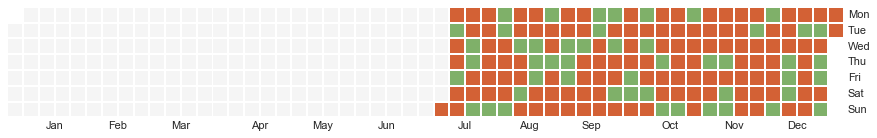

In [50]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', [(0, '#D36135'), (.5,'#ECE4B7'), (1,'#7FB069')])

listing_cal = (calendar_a.available[calendar_a.listing_id == listings.index[0]] == 't').astype('int')
listing_cal.index = pd.to_datetime(list(set(calendar_a.date)))
calmap.yearplot(listing_cal, cmap=cmap);

We can then calculate the proportion of listings that are available each day for the rest of the year 2019:

In [51]:
def daily_availability(calendar_data, return_prop=True):
    """Returns proportion of listings that are available each day in 2019"""
    avail_counts = calendar_data.groupby(['date','available']).size()[:'2019-12-31']
    available = avail_counts[1::2]
    if return_prop:
        unavailable = avail_counts[::2]
        availability = available / np.c_[available, unavailable].sum(1)
    else: availability = available
    last_index = int(np.where(availability.index.levels[0] == '2020-01-01')[0])
    availability.index = pd.to_datetime(availability.index.levels[0][:last_index])
    return availability

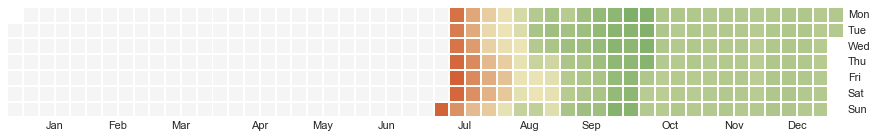

In [52]:
calmap.yearplot(daily_availability(calendar_a), cmap=cmap);

We can then see what daily availability looks like in some of the major neighborhoods in Seattle:

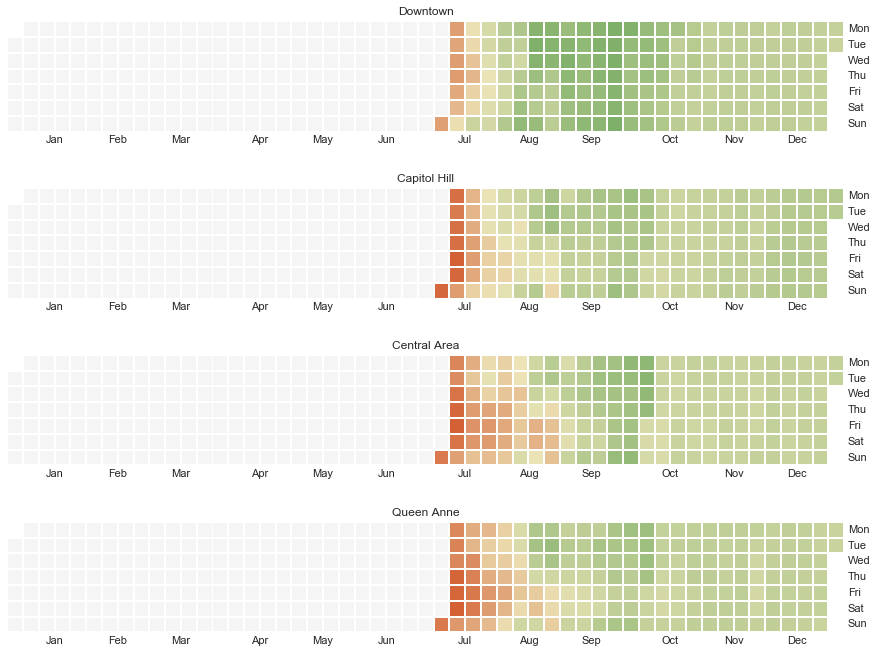

In [53]:
hoods = ['Downtown', 'Capitol Hill', 'Central Area', 'Queen Anne']

glob_min, glob_max = daily_availability(calendar_a).describe()[['min', 'max']]

fig = plt.figure(figsize=(15, 12))
grid = plt.GridSpec(len(hoods), 1, hspace=.1, wspace=.2)
for i, hood in enumerate(hoods):
    hood_listings = list(listings.index[listings.neighbourhood_group_cleansed == hood])
    calendar_sub = calendar_a.loc[calendar_a.listing_id.isin(hood_listings)]
    availability = daily_availability(calendar_sub)
    #pad with global max and min to make sure colorscale is constant
    availability[pd.to_datetime('2020-01-01')] = glob_min
    availability[pd.to_datetime('2020-01-02')] = glob_max
    ax=fig.add_subplot(grid[i,0])
    calmap.yearplot(availability, figure=fig, cmap=cmap, norm=None)
    ax.set_title(hood)

## 4.2. Daily prices
<a id='daily_prices'></a>

In [55]:
calendar_p = pd.read_csv('data/calendar_train_price.csv')

Let's take a look at how prices vary over the course of a year. First we can look at the prices over the next year for several individual listings:

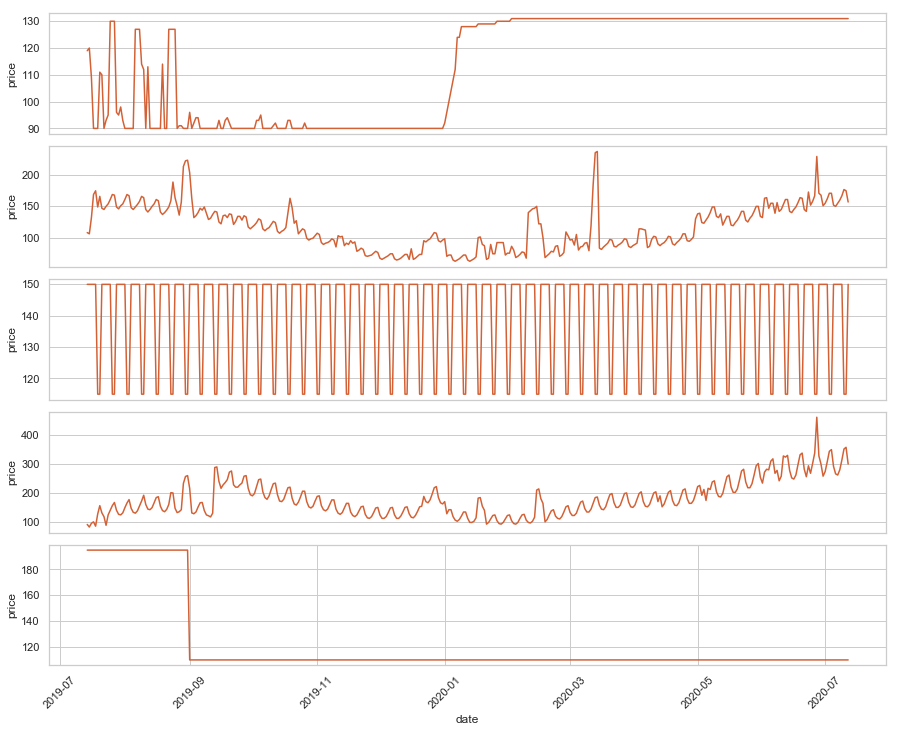

In [57]:
listing_ids = listings.index[:5]

fig = plt.figure(figsize=(15, 12))
grid = plt.GridSpec(len(listing_ids), 1, hspace=.1, wspace=.2)

for i, listing_id in enumerate(listing_ids):
    ax=fig.add_subplot(grid[i,0])
    sns.lineplot(x=pd.to_datetime(calendar_p.date[calendar_p.listing_id == listing_id]),
                 y=calendar_p.price[calendar_p.listing_id == listing_id])
    if i < (len(listing_ids) - 1):
        plt.xticks([])
        ax.set_xlabel('')
plt.xticks(rotation=45);

For some listings, we see high-frequency peaks, which represent higher prices on weekends. Otherwise it is hard to say anything general about prices over the year. Let's plot the median price on each day to cut through some of the noise:

In [59]:
daily_med_prices = calendar_p.groupby('date').price.median()[:365]

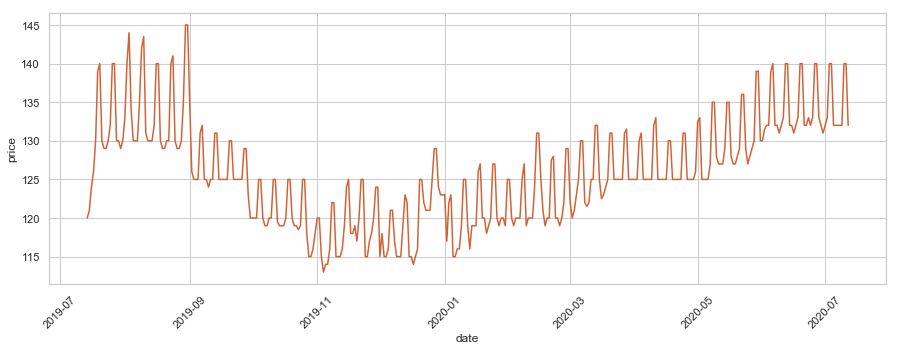

In [60]:
sns.lineplot(x=pd.to_datetime(daily_med_prices.index), y=daily_med_prices)
plt.xticks(rotation=45);

We again see high-frequency weekend spikes, as well as an extended peak over the summer and a smaller peak near the end of the year.

# 5. The reviews file
<a id='reviews'></a>
Now we'll take a look at the reviews file:

In [61]:
reviews = pd.read_csv('data/reviews_train.csv')

The reviews file contains the full text of every review for each listing, along with the name of the reviewer. Let's take a look at the first five:

In [62]:
for review in range(5):
    print('Property ' + str(reviews.listing_id[review]) + ':')
    print_quote(reviews.comments[review].replace('\n\n', '\n>\n>'))

Property 5422159:


>Cozy apartment located within steps all the downtown attractions Seattle has to offer. Would highly recommend this to anyone staying downtown.

Property 11867748:


>What a great location, I would recommend this location to anyone visiting Seattle. Perfect for a family!

Property 26456565:


>Great apartment in a convenient location. A bunch of good restaurants were just a short walk away and we definitely appreciated the parking in the driveway! Would recommend!

Property 189156:


>Great time near Alki Beach

Property 7921065:


>Spectacular!!! Don't hesitate to rent this place. Staying on Tugboat Sally exceeded all my expectations. It was immaculate -- sparkling clean. The hosts did a great job with outfitting her with creature comforts while maintaining the history and the spirit of the tug. The location is FAB. One thing to note is the city has Lime Bike and other bike sharing service where you can pick up and drop off a bike anywhere -- that means you can easily bike from Sally to lots of great restaurants. Other tips -- Ballard Farmers Market is really fun and a close bike ride away.  Metropolitan Market is close by (bike or Uber) and is a fun gourmet market for supplies. To be honest, I was a bit worried about being motion sick (as I am prone to that) but although sometimes there was a bit of a wake depending on boat traffic, I did great. No problems there. This was an amazing, not to miss experience! Can't wait to return.

We'll take a closer look at the reviews in another notebook.

# 6. Price outliers
<a id='outliers'></a>

Let's take a look at the descriptions for some of the extremely high-priced properties, starting with those listed at \$2,000 or more:

In [63]:
extreme_descriptions = listings.summary[listings.price >= 2000]
for i, description in enumerate(extreme_descriptions):
    print('Listing ' + str(extreme_descriptions.index[i]) + ':')
    print_quote(description)

Listing 34942657:


>Tucked into the historic Seattle neighborhood of Georgetown is the city’s newest hot spot for fashion shows, Meetups, birthday celebrations, holiday parties, photo and video shoots, private events and business meetings. Day use only (no beds/sleeping accommodations, or overnight use). We're the unique and completely transformable setting you’ve been searching for. Host your next event, class or Meetup in our industrial city-chic space with a speakeasy vibe!

Listing 34940717:


>Open floor plan with living room, dining room, bar top and formal sitting room with HUGE Bedroom.  Walk in closet, blackout bedroom shades and screened windows, Personal heating system, Smart home with smart locks, Alexa enabled lighting,Shared bathroom with marbled walls and flooring, washer and dryer -	No smoking

Listing 27372338:


>This impressive home has wonderful light and is convenient.  Great neighborhood and location.  Close to downtown,  A short walk Madison dining & shopping district.  The beautiful Washington Park Arboretum a short walk.    This home is located in McGilvra Elementary school district. Convenient to headquarters, hospitals and shopping.  Easy transportation to Amazon, Microsoft, Seattle University, University of Washington and hospitals.   Easy access to I-90 for T-Mobile and Boeing

Listing 28266972:


>Cute Queen Anne 1923 home located on the best street in Seattle. 180 degree views of the water. Safe, fully sufficient with off street parking. Not going to find this house under 2.7 million on Queen Anne

Listing 5956968:


>We're renting out a small private unit of one of Seattle's most beautiful houses to creative travelers.  The unit has it's own entrance to give you privacy in a cozy room with a new bed, great view/light, antiques and a newly remodeled bathroom.  No kitchen.

Listing 14128421:


>Place close to Asia Food Market. Comfy bed & great neighborhood. Full set of towels. Several types of tea & coffee machine provided to brighten the start of your day.  All amenities are available at the discretion of management, we deeply regret this inconvenience & statement. All guests need to show respect to host & other guests at all times. This is a home. No drink No smoke and NO drugs.  Early check in for $30 extra charge.

Only the first listing, an event space, seems to justify such a high daily price. We may want to drop some of these listings.

Now we'll take a look at the cluster of listings priced at \$1,000 per night (on closer inspection, it turns out they're priced at \$999 per night). We'll also take a look at who the hosts are for these listings:

In [64]:
thousand_descriptions = listings.summary[listings.price == 999]
for i, description in enumerate(thousand_descriptions):
    print('Listing ' + str(thousand_descriptions.index[i]) + ', host name ' + 
          str(listings.host_name[thousand_descriptions.index[i]]) + ':')
    print_quote(description)

Listing 22446738, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 15898292, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment. Note: Travel apartments at this property do not feature air conditioning.

Listing 1200083, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 15898102, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 22446732, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 32917964, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32918336, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 15898247, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 5785382, host name Stay Alfred:


>Come home to this upscale 1-bedroom, 1-bath condo with old-world charm in one of Seattle’s historic brick buildings. Enjoy a rooftop patio with skyline and bay views! An easy five-minute walk from these fancy digs puts you in the heart of Seattle’s iconic downtown sites, such as Pike Place Market and Waterfront Park, with the Seattle Art Museum just one block away!

Listing 934123, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 16379881, host name Stay Alfred:


>With huge windows offering awesome water views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 22164869, host name Stay Alfred:


>Upscale travel apartment with resort-style amenities and cyber lounge in Seattle’s Belltown neighborhood

Listing 32917311, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 22446734, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 22446735, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 32916880, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 21564045, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 32918763, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917301, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 21560490, host name Stay Alfred:


>A chic travel apartment in a stylish building with a rooftop deck, plus a hip billiards room and cutting-edge 24-hour gym, these posh downtown Seattle digs make a great launching pad for your Belltown adventures.

Listing 21560487, host name Stay Alfred:


>A chic travel apartment in a stylish building with a rooftop deck, plus a hip billiards room and cutting-edge 24-hour gym, these posh downtown Seattle digs make a great launching pad for your Belltown adventures.

Listing 32918771, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32918350, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 21560493, host name Stay Alfred:


>A chic travel apartment in a stylish building with a rooftop deck, plus a hip billiards room and cutting-edge 24-hour gym, these posh downtown Seattle digs make a great launching pad for your Belltown adventures.

Listing 32916859, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32918360, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 22750596, host name Stay Alfred:


>Handsome travel apartment with oversized windows and a host of fitness, fun, and business amenities including fancy courtyard and theater in Seattle’s Belltown neighborhood.

Listing 32918752, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 22446742, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 32917309, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917936, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 935671, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 32918349, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 7807090, host name Stay Alfred:


>Upscale travel apartment with resort-style amenities and cyber lounge in Seattle’s Belltown neighborhood

Listing 32917953, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 7807169, host name Stay Alfred:


>Upscale travel apartment with resort-style amenities and cyber lounge in Seattle’s Belltown neighborhood

Listing 32917959, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32918743, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917948, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917318, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917950, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 23038660, host name Stay Alfred:


>Handsome travel apartment with oversized windows and a host of fitness, fun, and business amenities including fancy courtyard and theater in Seattle’s Belltown neighborhood.

Listing 22446749, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 22446746, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 22164873, host name Stay Alfred:


>Upscale travel apartment with resort-style amenities and cyber lounge in Seattle’s Belltown neighborhood

Listing 2191633, host name Stay Alfred:


>With huge windows offering awesome water views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 32918346, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 22446744, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 32917315, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917313, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32916853, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32916875, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 3345341, host name Amy:


>100% Walk Score close to the Convention Center, Westlake Station, Pike Place Market, Amazon, Belltown, Capitol Hill, and more. Spotless, reliable, accommodating, and professional hosts!

Listing 2187615, host name Stay Alfred:


>Come home to this upscale 1-bedroom, 1-bath condo with old-world charm in one of Seattle’s historic brick buildings. Enjoy a rooftop patio with skyline and bay views! An easy five-minute walk from these fancy digs puts you in the heart of Seattle’s iconic downtown sites, such as Pike Place Market and Waterfront Park, with the Seattle Art Museum just one block away!

Listing 34090646, host name Corp Condos & Apts:


>Gorgeous Studio Unit in the heart of Seattle - First Hill. Professionally managed and fully stocked w/ everything from salt, pepper, shampoo and body-wash to a sparkling water welcome gift!

Listing 32916867, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917298, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 1084117, host name Stay Alfred:


>With huge windows offering awesome water views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 22446741, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Listing 931785, host name Stay Alfred:


>With huge windows offering awesome water views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 32916871, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 20920545, host name Alfred:


>This is a TEST listing and is NOT bookable.  This room has a queen bed.  It also has a large bathroom with jetted tub.  The room is extremely sound proof and in an isolated corner of the house.

Listing 32918766, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 7807268, host name Stay Alfred:


>Upscale travel apartment with resort-style amenities and cyber lounge in Seattle’s Belltown neighborhood

Listing 8308386, host name Stay Alfred:


>Handsome travel apartment with oversized windows and a host of fitness, fun, and business amenities including fancy courtyard and theater in Seattle’s Belltown neighborhood.

Listing 21560495, host name Stay Alfred:


>A chic travel apartment in a stylish building with a rooftop deck, plus a hip billiards room and cutting-edge 24-hour gym, these posh downtown Seattle digs make a great launching pad for your Belltown adventures.

Listing 14425157, host name Stay Alfred:


>With huge windows offering awesome water views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 2-bedroom, 2-bath luxury apartment.

Listing 32918343, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32895435, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917957, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 32917955, host name Stay Alfred:


>Modern loft-style vacation rental in the Loop neighborhood.

Listing 22446740, host name Stay Alfred:


>With huge windows offering awesome Seattle views and an address that’s just three blocks from glimmering Elliott Bay, plus a community sundeck with bay views, heated pools and a basketball court, there’s no better place to stay in downtown Seattle than this 1-bedroom, 1-bath luxury apartment.

Many of the listing descriptions are exactly the same. These could represent genuinely different apartments in the same building under the same management (Stay Alfred, apparently) or they could be duplicate entries for the same listing.

We have another source for listing price data, the calender file. Let's see what the prices are for some of these listings in the calendar file:

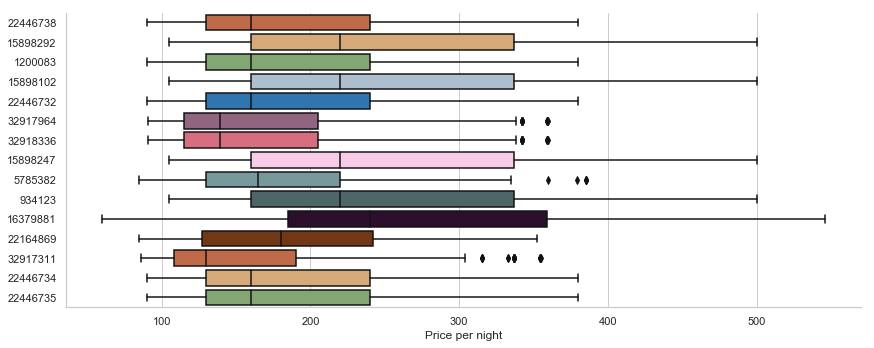

In [67]:
calendar_p = calendar_p.astype({'listing_id':'category'})
pt_plot = sns.catplot(x='price', y='listing_id', data=calendar_p[calendar_p.listing_id.isin(thousand_descriptions.index[:15])],
                      kind='box', aspect=2.5, order=thousand_descriptions.index[:15], palette=color_palette)
pt_plot.set(xlabel='Price per night', ylabel='');

None of the listings are \$999 on any day of the year. Most tend to be between \$200 and \$400. We will want to address these apparent errors before we do any modeling.